In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


In [2]:
@dataclasses.dataclass(frozen=True)
class VlasovPoissonSolverParticles(VlasovPoissonSolver):
    f_eq_: Callable[[Array, Array], Array]


    # Generate particles with no weights
    def generate_particles(self):
        mesh = self.mesh
        f_eq_ = self.f_eq_
        x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
        v_vals = jnp.linspace(-mesh.period_v + 0.5 * mesh.dv,
                                mesh.period_v - 0.5 * mesh.dv, mesh.nv)
        x_flat = jnp.repeat(x_vals, mesh.nv)
        v_flat = jnp.tile(v_vals, mesh.nx)
        
        # Create the flat particle array
        particles = jnp.stack([x_flat, v_flat], axis=-1)

        return particles

    # Generate particles for equilibrium two-stream case
    def generate_particles_equilibrium_two_stream(self):
        # Extract the mesh parameters and the function
        mesh = self.mesh
        f_eq_ = self.f_eq_

        # Define a JIT-compatible helper function
        @jax.jit
        def generate_particles_jit():
            # Vectorized over x and v grid points
            x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
            v_vals = jnp.linspace(-mesh.period_v + 0.5 * mesh.dv,
                                  mesh.period_v - 0.5 * mesh.dv, mesh.nv)

            # Compute weights for each (x, v)
            def compute_weights(x, v):
                weights = f_eq_(x, v) * mesh.dx * mesh.dv
                weight_sum = jnp.sum(weights)
                return weights
                #return jax.lax.cond(weight_sum != 0,
                #                    lambda: weights * (mesh.dx / weight_sum),
                #                    lambda: weights)

            # Use vmap for vectorized computation over x and v
            normalized_weights = jax.vmap(lambda x: jax.vmap(lambda v: compute_weights(x, v))(v_vals))(x_vals)

            # Flattening x, v, and normalized_weights to a flat list of tuples (x, v, weight)
            x_flat = jnp.repeat(x_vals, mesh.nv)
            v_flat = jnp.tile(v_vals, mesh.nx)
            w_flat = normalized_weights.flatten()

            # Create the flat particle array
            particles = jnp.stack([x_flat, v_flat, w_flat], axis=-1)

            return particles

        # Call the JIT-ed function
        return generate_particles_jit()

    # Generate particles for non-equilibrium two-stream case
    def generate_particles_two_stream(self, f, epsilon, beta):
        # Extract mesh parameters
        mesh = self.mesh

        # Define a JIT-compatible helper function
        @jax.jit
        def generate_particles_jit():
            # Vectorized over x and v grid points
            x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
            v_vals = jnp.linspace(-mesh.period_v + 0.5 * mesh.dv,
                                  mesh.period_v - 0.5 * mesh.dv, mesh.nv)

            # Compute weights for each x
            def compute_weights(x,v):
                #normalization_factor = (1 + epsilon * jnp.cos(beta * x)) * mesh.dx
                weights = f(x, v) * mesh.dx * mesh.dv
                weight_sum = jnp.sum(weights)
                return weights
                #return jax.lax.cond(weight_sum != 0,
                #                    lambda: weights * (normalization_factor / weight_sum),
                #                    lambda: weights)

            # Use vmap for vectorized computation over x
            normalized_weights = jax.vmap(lambda x: jax.vmap(lambda v: compute_weights(x, v))(v_vals))(x_vals)

            # Flatten x, v, and normalized_weights to a flat list of tuples (x, v, weight)
            x_flat = jnp.repeat(x_vals, mesh.nv)
            v_flat = jnp.tile(v_vals, mesh.nx)
            w_flat = normalized_weights.flatten()

            # Create the flat particle array
            particles = jnp.stack([x_flat, v_flat, w_flat], axis=-1)

            return particles

        # Call the JIT-ed function
        return generate_particles_jit()


    def compute_rho(self, particles):
        mesh = self.mesh

        @jax.jit
        def compute_density_jit():
            x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
    
            # Extract positions and weights from particles
            positions = particles[:, 0]
            weights = particles[:, 2]
    
            # Determine the cell index for each particle based on its position
            cell_indices = jnp.floor_divide(positions, mesh.dx).astype(int)
    
            # Accumulate the weights in the corresponding x cells using segment_sum
            rho_x = jax.ops.segment_sum(weights, cell_indices, mesh.nx)
            
            # Normalize by the mesh spacing
            rho_x = rho_x / mesh.dx
    
            return x_vals, rho_x

        # Call the JIT-ed function
        return compute_density_jit()
    
    def compute_E_from_rho(self, rho: Array) -> Array:
        rho_hat = jnp.fft.fft(rho)
        E_hat = jnp.zeros_like(rho_hat)
        inv_multiplier = -1.0 / (1j * 2 * jnp.pi * jnp.fft.fftfreq(self.mesh.nx, d=self.mesh.period_x / self.mesh.nx)[1:])
        E_hat = E_hat.at[1:].set(inv_multiplier * rho_hat[1:])
        return jnp.real(jnp.fft.ifft(E_hat))

    # Verlet integration method for N^2 particles in 1D, with periodic boundary conditions
    def verlet_integration_particles(self, particles, num_steps):
        """
        Simulate the movement of particles using the Verlet integration scheme.
    
        Parameters:
        particles (array): Array of particles with shape (N, 3), where each particle is (x, v, weight)
        num_steps (int): Number of time steps
        
        Returns:
        particles: Updated array of particles after integration
        """
        mesh = self.mesh
        dt = self.dt
        positions = particles[:, 0]
        velocities = particles[:, 1]
    
        # Compute initial charge density and electric field
        x_centers, rho_x = self.compute_rho(particles)
        E_x = self.compute_E_from_rho(rho_x)
    
        # Interpolate the electric field at particle positions
        indices = jnp.floor(positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
        E_at_positions = E_x[indices]
    
        # Define the function to execute at each time step using jax.lax.fori_loop
        @jax.jit
        def step_fn(step, carry):
            positions, velocities, E_at_positions = carry
    
            # Update positions using Verlet's method
            new_positions = positions + velocities * dt + 0.5 * dt**2 * E_at_positions
    
            # Apply periodic boundary conditions on positions
            new_positions = new_positions % mesh.period_x
    
            # Compute the charge density and electric field at new positions
            updated_particles = jnp.column_stack((new_positions, velocities, particles[:, 2]))
            _, rho_x = self.compute_rho(updated_particles)
            E_x = self.compute_E_from_rho(rho_x)
    
            # Interpolate the electric field at new positions
            new_indices = jnp.floor(new_positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
            E_at_positions_new = E_x[new_indices]
    
            # Update velocities using the average electric field
            new_velocities = velocities + 0.5 * dt * (E_at_positions + E_at_positions_new)
    
            # Apply velocity clamping: restrict velocities to the range [-period_v, period_v]
            new_velocities = jnp.clip(new_velocities, -mesh.period_v, mesh.period_v)
    
            return new_positions, new_velocities, E_at_positions_new
    
        # Use jax.lax.fori_loop for looped operations to preserve JIT compatibility
        final_positions, final_velocities, _ = jax.lax.fori_loop(
            0, num_steps, step_fn, (positions, velocities, E_at_positions)
        )
    
        # Update the particles array with the final positions and velocities
        updated_particles = jnp.column_stack((final_positions, final_velocities, particles[:, 2]))
    
        return updated_particles


    # Verlet integration method for N^2 particles in 1D, with periodic boundary conditions
    def verlet_integration_particles_with_H(self, particles, num_steps, H):
        """
        Simulate the movement of particles using the Verlet integration scheme.
    
        Parameters:
        particles (array): Array of particles with shape (N, 3), where each particle is (x, v, weight)
        num_steps (int): Number of time steps
        
        Returns:
        particles: Updated array of particles after integration
        """
        mesh = self.mesh
        dt = self.dt
        positions = particles[:, 0]
        velocities = particles[:, 1]
    
        # Compute initial charge density and electric field
        x_centers, rho_x = self.compute_rho(particles)
        E_x = self.compute_E_from_rho(rho_x)
    
        # Interpolate the electric field at particle positions
        indices = jnp.floor(positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
        E_at_positions = E_x[indices]
        H_at_positions = H(x_centers)[indices]
    
        # Define the function to execute at each time step using jax.lax.fori_loop
        @jax.jit
        def step_fn(step, carry):
            positions, velocities, E_at_positions, H_at_positions = carry
    
            # Update positions using Verlet's method
            new_positions = positions + velocities * dt + 0.5 * dt**2 * (E_at_positions + H_at_positions)
    
            # Apply periodic boundary conditions on positions
            new_positions = new_positions % mesh.period_x
    
            # Compute the charge density and electric field at new positions
            updated_particles = jnp.column_stack((new_positions, velocities, particles[:, 2]))
            x_centers, rho_x = self.compute_rho(updated_particles)
            E_x = self.compute_E_from_rho(rho_x)
    
            # Interpolate the electric field at new positions
            new_indices = jnp.floor(new_positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
            E_at_positions_new = E_x[new_indices]
            H_at_positions_new = H(x_centers)[new_indices]
    
            # Update velocities using the average electric field
            new_velocities = velocities + 0.5 * dt * (E_at_positions + E_at_positions_new + H_at_positions + H_at_positions_new)
    
            # Apply velocity clamping: restrict velocities to the range [-period_v, period_v]
            new_velocities = jnp.clip(new_velocities, -mesh.period_v, mesh.period_v)
    
            return new_positions, new_velocities, E_at_positions_new, H_at_positions_new
    
        # Use jax.lax.fori_loop for looped operations to preserve JIT compatibility
        final_positions, final_velocities, _ , _ = jax.lax.fori_loop(
            0, num_steps, step_fn, (positions, velocities, E_at_positions, H_at_positions)
        )
    
        # Update the particles array with the final positions and velocities
        updated_particles = jnp.column_stack((final_positions, final_velocities, particles[:, 2]))
    
        return updated_particles



In [3]:
# Function to plot particles with color representing their weights
def plot_particles(particles, mesh):
    """
    Plot the particles with color representing their weights at a specific time step.

    Parameters:
    particles (list): List of particles (x, v, weight)
    v_max (float): Maximum velocity
    L (float): Length of the domain for x
    step (int): The current time step
    """
    x_vals = particles[:,0]
    v_vals = particles[:,1]
    weights = particles[:,2]
    #weights_norm = weights/jnp.linalg.norm(weights)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x_vals, v_vals, c=weights, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Weight')
    plt.xlim(0, mesh.period_x)
    plt.ylim(-mesh.period_v, mesh.period_v)
    plt.title(f'Particle Distribution at final time')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.show()

In [4]:
def two_stream_distribution_(x, v, v_bar, epsilon, beta):
    return (1 / (2 * jnp.sqrt(2 * jnp.pi))) * (
        jnp.exp(-(v - v_bar)**2 / 2) + jnp.exp(-(v + v_bar)**2 / 2)
        ) * (1 + epsilon * jnp.cos(beta * x))


def two_stream_distribution(x, v, alpha, k):
    return (1 / (jnp.sqrt(2 * jnp.pi))) * (jnp.exp(-v**2/2)*v**2) * (1 + alpha * jnp.cos(k * x))

#@jax.jit
#def two_stream_distribution(x, v, mu_1, mu_2, alpha):
#    return (alpha * jnp.exp(-0.5 * (x - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (v - mu2)**2)) / jnp.sqrt(2 * jnp.pi)


In [41]:
# Problem setup
nx = 256
nv = 256
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
num_steps = int(t_final/dt)
L = 4 * jnp.pi
LV = 4.0

In [42]:
mesh = make_mesh(L, LV, nx, nv)

alpha = 0.5
v_max = 8
alpha = 0.01
k_0 = 0.5
f_eq_ = lambda x, v: two_stream_distribution(x, v, 0, k_0)
f_eq = f_eq_(mesh.X, mesh.V)
f_iv_ = lambda x, v: two_stream_distribution(x, v, alpha, k_0)
#f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq


In [43]:
solver = VlasovPoissonSolverParticles(mesh=mesh, dt=dt, f_eq=jnp.array(f_eq), f_eq_=f_eq_)

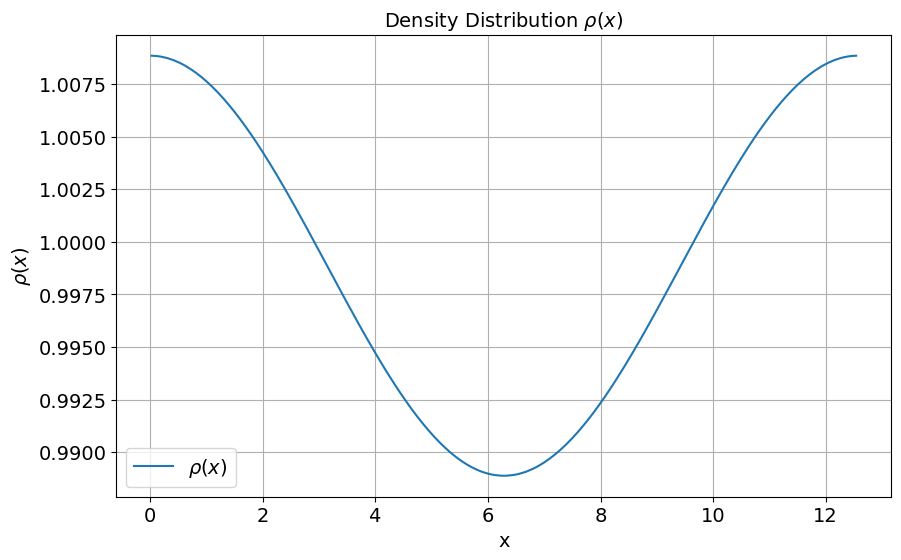

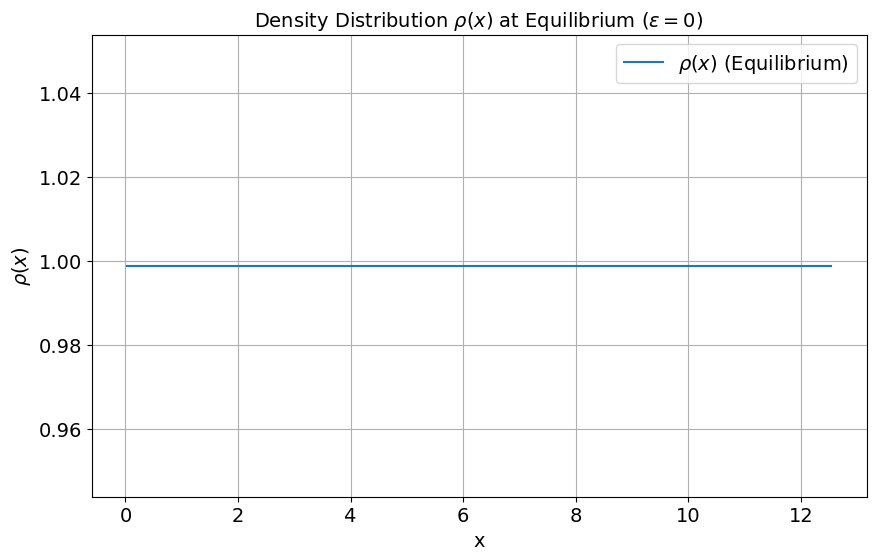

In [44]:
# Generate particles using the two-stream distribution
particles_init = solver.generate_particles_two_stream(f_iv_, alpha, k_0)

# Generate particles for the equilibrium distribution
equilibrium_particles = solver.generate_particles_equilibrium_two_stream()


# Compute the density rho(x)
x_centers, rho_x = solver.compute_rho(particles)

# Plot the density rho(x)
plt.figure(figsize=(10, 6))
plt.plot(x_centers, rho_x, label=r'$\rho(x)$')
plt.title(r'Density Distribution $\rho(x)$')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

# Compute the density rho(x) for the equilibrium state
x_centers_eq, rho_x_eq = solver.compute_rho(equilibrium_particles)

# Plot the density rho(x) for the equilibrium state
plt.figure(figsize=(10, 6))
plt.plot(x_centers_eq, rho_x_eq, label=r'$\rho(x)$ (Equilibrium)')
plt.title(r'Density Distribution $\rho(x)$ at Equilibrium ($\epsilon=0$)')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

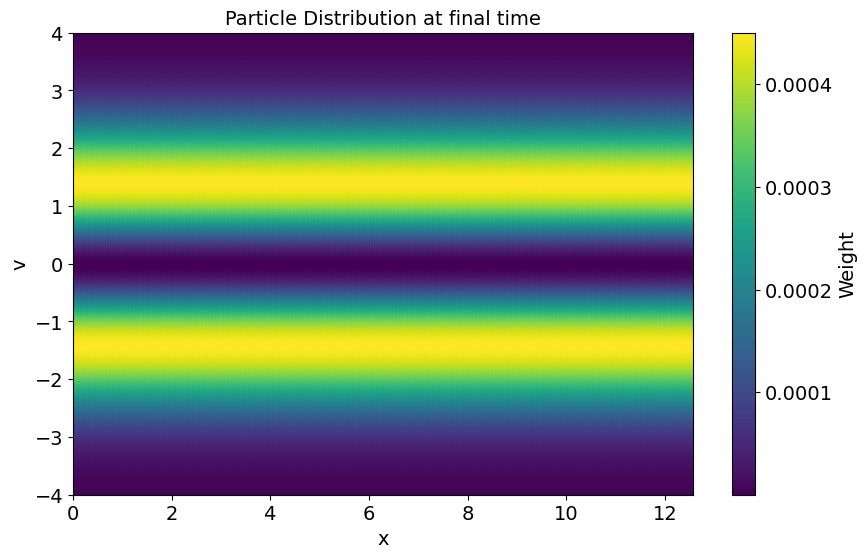

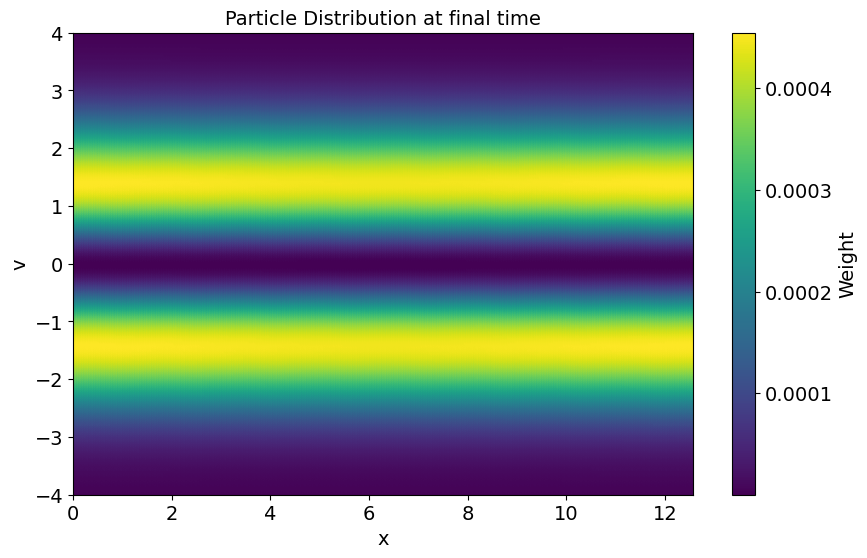

In [45]:
plot_particles(equilibrium_particles, mesh)
plot_particles(particles, mesh)

In [46]:
updated_particles = solver.verlet_integration_particles(particles_init, num_steps)

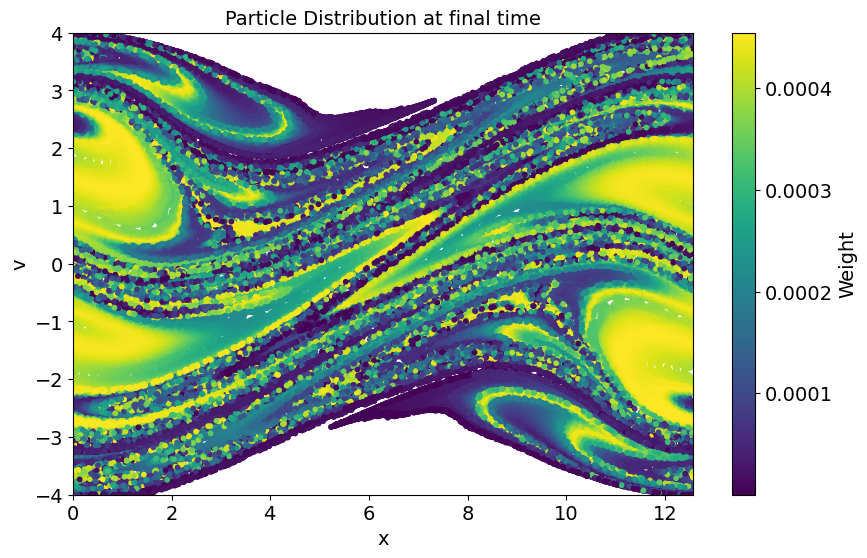

In [47]:
plot_particles(updated_particles, mesh)

In [48]:
a_k = 0.05
H = lambda x: a_k * jnp.cos(k_0 * x)  # External field function H(x)

updated_particles_H = solver.verlet_integration_particles_with_H(particles_init, num_steps, H)

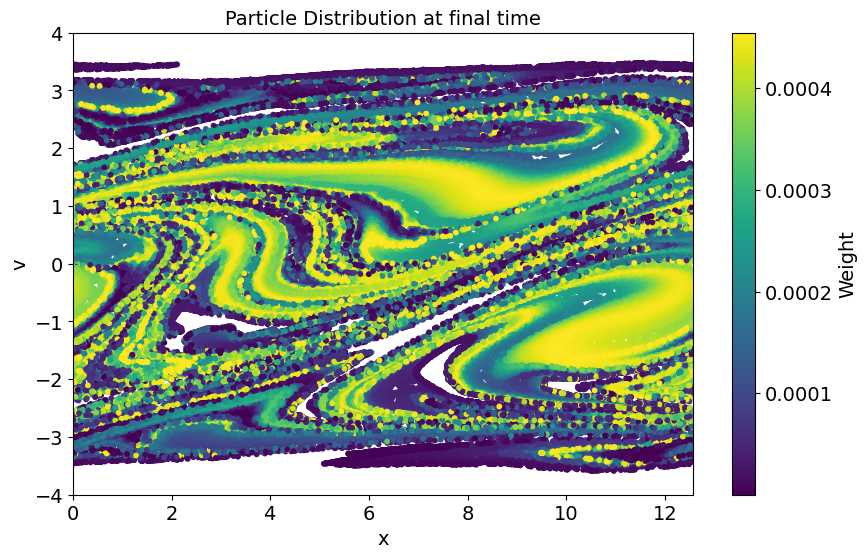

In [49]:
plot_particles(updated_particles_H, mesh)

In [50]:
from ott.geometry import pointcloud
from ott.solvers import linear

In [54]:
def reg_ot_cost(a_k: float, y: Array, solver: VlasovPoissonSolver, particles_init: Array, num_steps: int) -> float:
    H = lambda x: a_k * jnp.cos(0.5 * x)
    particles = solver.verlet_integration_particles_with_H(particles_init, num_steps, H)
    geom = pointcloud.PointCloud(particles, y)
    ot = linear.solve(geom)
    return ot.reg_ot_cost

In [52]:
a_ks = jnp.linspace(-0.5, 0.5, 21)

In [55]:
costs = np.zeros(len(a_ks))
for i in range(len(a_ks)):
    costs[i] = reg_ot_cost(a_ks[i], equilibrium_particles, solver, particles_init, num_steps)

2024-10-30 20:06:48.442329: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 16.77GiB (18004409615 bytes) by rematerialization; only reduced to 32.00GiB (34364195809 bytes), down from 32.00GiB (34364459037 bytes) originally
2024-10-30 20:06:59.324374: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.00GiB (rounded to 34360002816)requested by op 
2024-10-30 20:06:59.324755: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *___________________________________________________________________________________________________
E1030 20:06:59.324805 2030749 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 34360002632 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 34360002632 bytes.

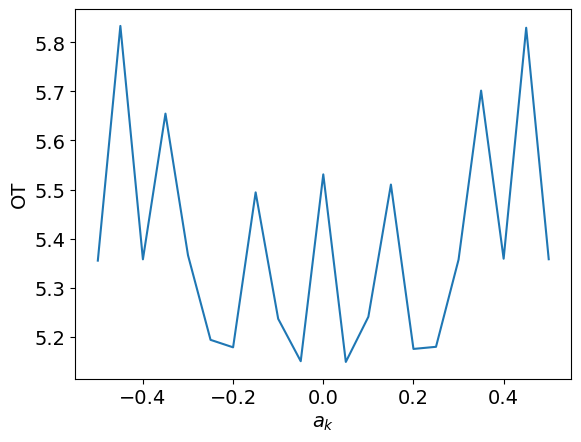

In [40]:
plt.plot(a_ks, costs)
plt.ylabel("OT")
plt.xlabel("$a_k$")
plt.show()